In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir(r'/content/drive/My Drive/torchray_master')  # Change the directory to torchRay-master folder

# Requirements

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [ ]:
train_dir = '/content/drive/My Drive/torchray_master/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/content/drive/My Drive/torchray_master/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

val_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4407 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [ ]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=10,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [ ]:
model=load_model('/content/drive/My Drive/torchray_master/models/HMT.h5')

In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
print('log/train/' + os.listdir('log/train'))
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

## **#Task 3**

In [ ]:
##Task3-Question3.b
loss, acc=model.evaluate_generator(generator=test_generator)

print('Overall classification accuracy: %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Overall classification accuracy: 83.468


In [ ]:
predicted=model.predict_generator(test_generator)
predicted_class=np.array([np.argmax(x) for x in predicted])

In [ ]:
test_label = test_generator.labels
y_testt= tensorflow.keras.utils.to_categorical(test_label)

In [ ]:
##Task3-Question3.c
predicted_class_=tensorflow.keras.utils.to_categorical(predicted_class) 

classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

# we know that recall for say class positive is (TP/(TP+FN)) or TP/P this is called sensitivity, recall, class accuracy or the class recognition rate 
for i in range(8): 
  print("The accuracy of class "+classes[i]+" is: "+str(round(metrics.classification_report(y_testt,predicted_class_,output_dict=True)[str(i)]['recall'],4)))


The accuracy of class Tumor is: 0.8548
The accuracy of class Stroma is: 0.7581
The accuracy of class Complex is: 0.7742
The accuracy of class Lympho is: 0.8548
The accuracy of class Debris is: 0.6613
The accuracy of class Mucosa is: 0.8226
The accuracy of class Adiopse is: 0.9516
The accuracy of class Empty is: 1.0


<Figure size 432x288 with 0 Axes>

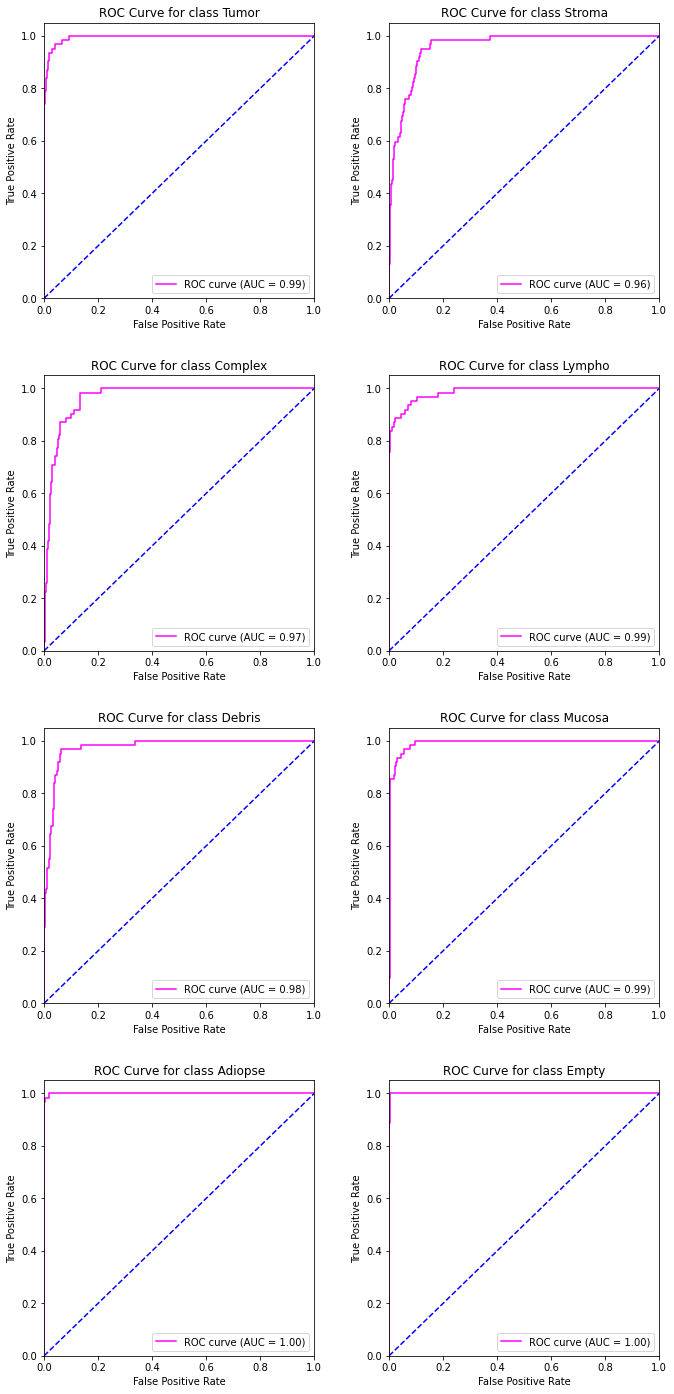

In [ ]:
##Task3-Question3.d
from sklearn.metrics import roc_curve, auc
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range (8) :
  fpr[i], tpr[i], _= roc_curve(y_testt[:,i], predicted[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i]) 
plt.figure()
#colors = cycle(["red", "blue","green", "pink","yellow", "teal","gold","aqua", "darkorange", "cornflowerblue"])
fig, axs = plt.subplots(4, 2, figsize=(10, 20)) 
for i, ax in zip(range(8), axs.ravel()):
  ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.2f)' % roc_auc[i]) 
  ax.plot([0, 1], [0, 1], 'b--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  ax.set_title('ROC Curve for class '+ classes[i]) 
  ax.legend(loc= "lower right")
  fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/torchray_master/ROC_Curve_HMT.png')

In [ ]:
# area under the curve (AUC) 
for i in range(8):
  print("The AUC of class "+ classes[i]+" is "+str(roc_auc[i]))

The AUC of class Tumor is 0.9944626133491898
The AUC of class Stroma is 0.9584881819533224
The AUC of class Complex is 0.9655492790248253
The AUC of class Lympho is 0.9864724245577523
The AUC of class Debris is 0.9751003419057529
The AUC of class Mucosa is 0.9919726475397651
The AUC of class Adiopse is 0.9996655269808236
The AUC of class Empty is 0.9997398543184183


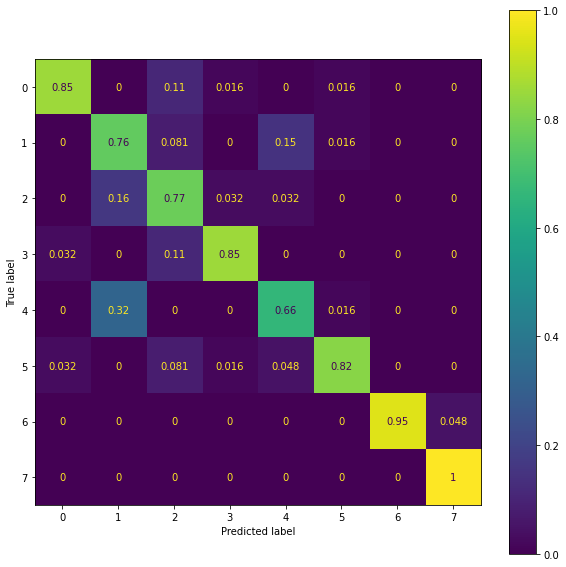

In [ ]:
##Task3-Question3.e
fig, ax=plt.subplots(figsize=(10,10))
metrics.ConfusionMatrixDisplay.from_predictions(test_label,predicted_class, normalize='true', ax=ax)
plt.savefig('/content/drive/My Drive/torchray_master/confusionMatrix_HMT.png')

In [ ]:
##Task3-Question3.f
precision, recall, f_1, _ = metrics.precision_recall_fscore_support(test_label, predicted_class, average='micro')
print("For the whole data set, the scores are: ")
print("Precision: "+str(precision))
print("Recall: " +str(recall))
print("F-1: "+str(f_1))
print()

for i in range(8):
  precision, recall, f_1, _ = metrics.precision_recall_fscore_support(test_label, predicted_class, labels=[i], average = 'micro')
  print("For class "+ classes[i]+", the scores are:")
  print("Precision: "+str(precision))
  print("Recall: " +str(recall))
  print("F-1: "+str(f_1))
  print()

For the whole data set, the scores are: 
Precision: 0.8346774193548387
Recall: 0.8346774193548387
F-1: 0.8346774193548387

For class Tumor, the scores are:
Precision: 0.9298245614035088
Recall: 0.8548387096774194
F-1: 0.8907563025210085

For class Stroma, the scores are:
Precision: 0.6103896103896104
Recall: 0.7580645161290323
F-1: 0.6762589928057554

For class Complex, the scores are:
Precision: 0.6666666666666666
Recall: 0.7741935483870968
F-1: 0.7164179104477612

For class Lympho, the scores are:
Precision: 0.9298245614035088
Recall: 0.8548387096774194
F-1: 0.8907563025210085

For class Debris, the scores are:
Precision: 0.7454545454545455
Recall: 0.6612903225806451
F-1: 0.7008547008547009

For class Mucosa, the scores are:
Precision: 0.9444444444444444
Recall: 0.8225806451612904
F-1: 0.8793103448275862

For class Adiopse, the scores are:
Precision: 1.0
Recall: 0.9516129032258065
F-1: 0.9752066115702479

For class Empty, the scores are:
Precision: 0.9538461538461539
Recall: 1.0
F-1:

In [ ]:
##Task3-Question4
import collections
Error_list=[]#indecies of mis-predicted samples in data set
True_list=[]#indecies of correctly classified samples 

for i,tp in zip(range(len(test_label)), (test_label==predicted_class)):
  if(tp==True):
    True_list.append(i)
  else:
    Error_list.append(i)

Error_list_Truelabels=[]
for i in range(len(Error_list)):
  Error_list_Truelabels.append(test_label[Error_list[i]])

frequencies=collections.Counter(Error_list_Truelabels)
print("Error for each class in decreasing order w.r.t. number of error:")
print(frequencies)
print()

Error for each class in decreasing order w.r.t. number of error:
Counter({4: 21, 1: 15, 2: 14, 5: 11, 0: 9, 3: 9, 6: 3})



In [ ]:
mismatch_4=[]
for i in range(len(Error_list_Truelabels)):
  if(Error_list_Truelabels[i]==4):
    mismatch_4.append(predicted_class[Error_list[i]])
print("List of false classification for Class 4: ")
print(mismatch_4)
print()

List of false classification for Class 4: 
[1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



In [ ]:
mismatch_1=[]
for i in range(len(Error_list_Truelabels)):
  if(Error_list_Truelabels[i]==1):
    mismatch_1.append(predicted_class[Error_list[i]])
print("List of false classification for Class 1: ")
print(mismatch_1)
print()

List of false classification for Class 1: 
[2, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 5, 2]



# Explanation

Load the explaier library

In [ ]:
from xai_utils import *

Load a batch of images

In [ ]:
test_generator.reset()

In [ ]:
image_batch,label_batch=test_generator.next()

Classes:

In [ ]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [ ]:
index=8

In [ ]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [ ]:
layers=[['conv2d_3']]

In [ ]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 4.14 s, sys: 507 ms, total: 4.65 s
Wall time: 3.19 s


## Integrated gradient


In [ ]:
def Integrated_gradient(input, model, label, knots=range(50)):
  baseline = np.zeros(input.shape)
  path = np.asarray([baseline + (i/(knots[-1]+1))*(input-baseline) for i in knots]) 

  with tensorflow.GradientTape() as tape:
    inputs = tensorflow.cast(path, tensorflow.float32) 
    tape.watch(inputs)
    predictions = model(inputs)
    loss = predictions[:, label]

  
  grads = tape.gradient(loss, inputs)
  grads = (grads[:-1] + grads[1:])/ 2.0
  temp = (input-baseline)*np.average(grads, axis=0) 

  integrated_gradients = np.expand_dims(np.average(temp, axis=2), 2) * [0, 255, 0]
  max=integrated_gradients.max()
  integrated_gradients /= max

  return integrated_gradients

## Plot the results

Text(0.5, 1.0, 'Explanation map (RISE)')

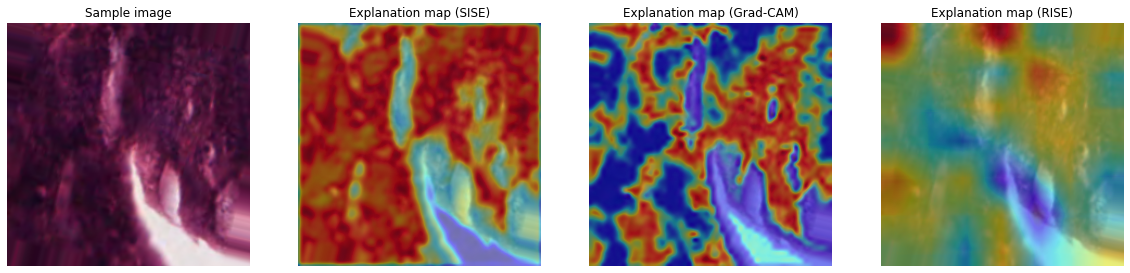

In [ ]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,4,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


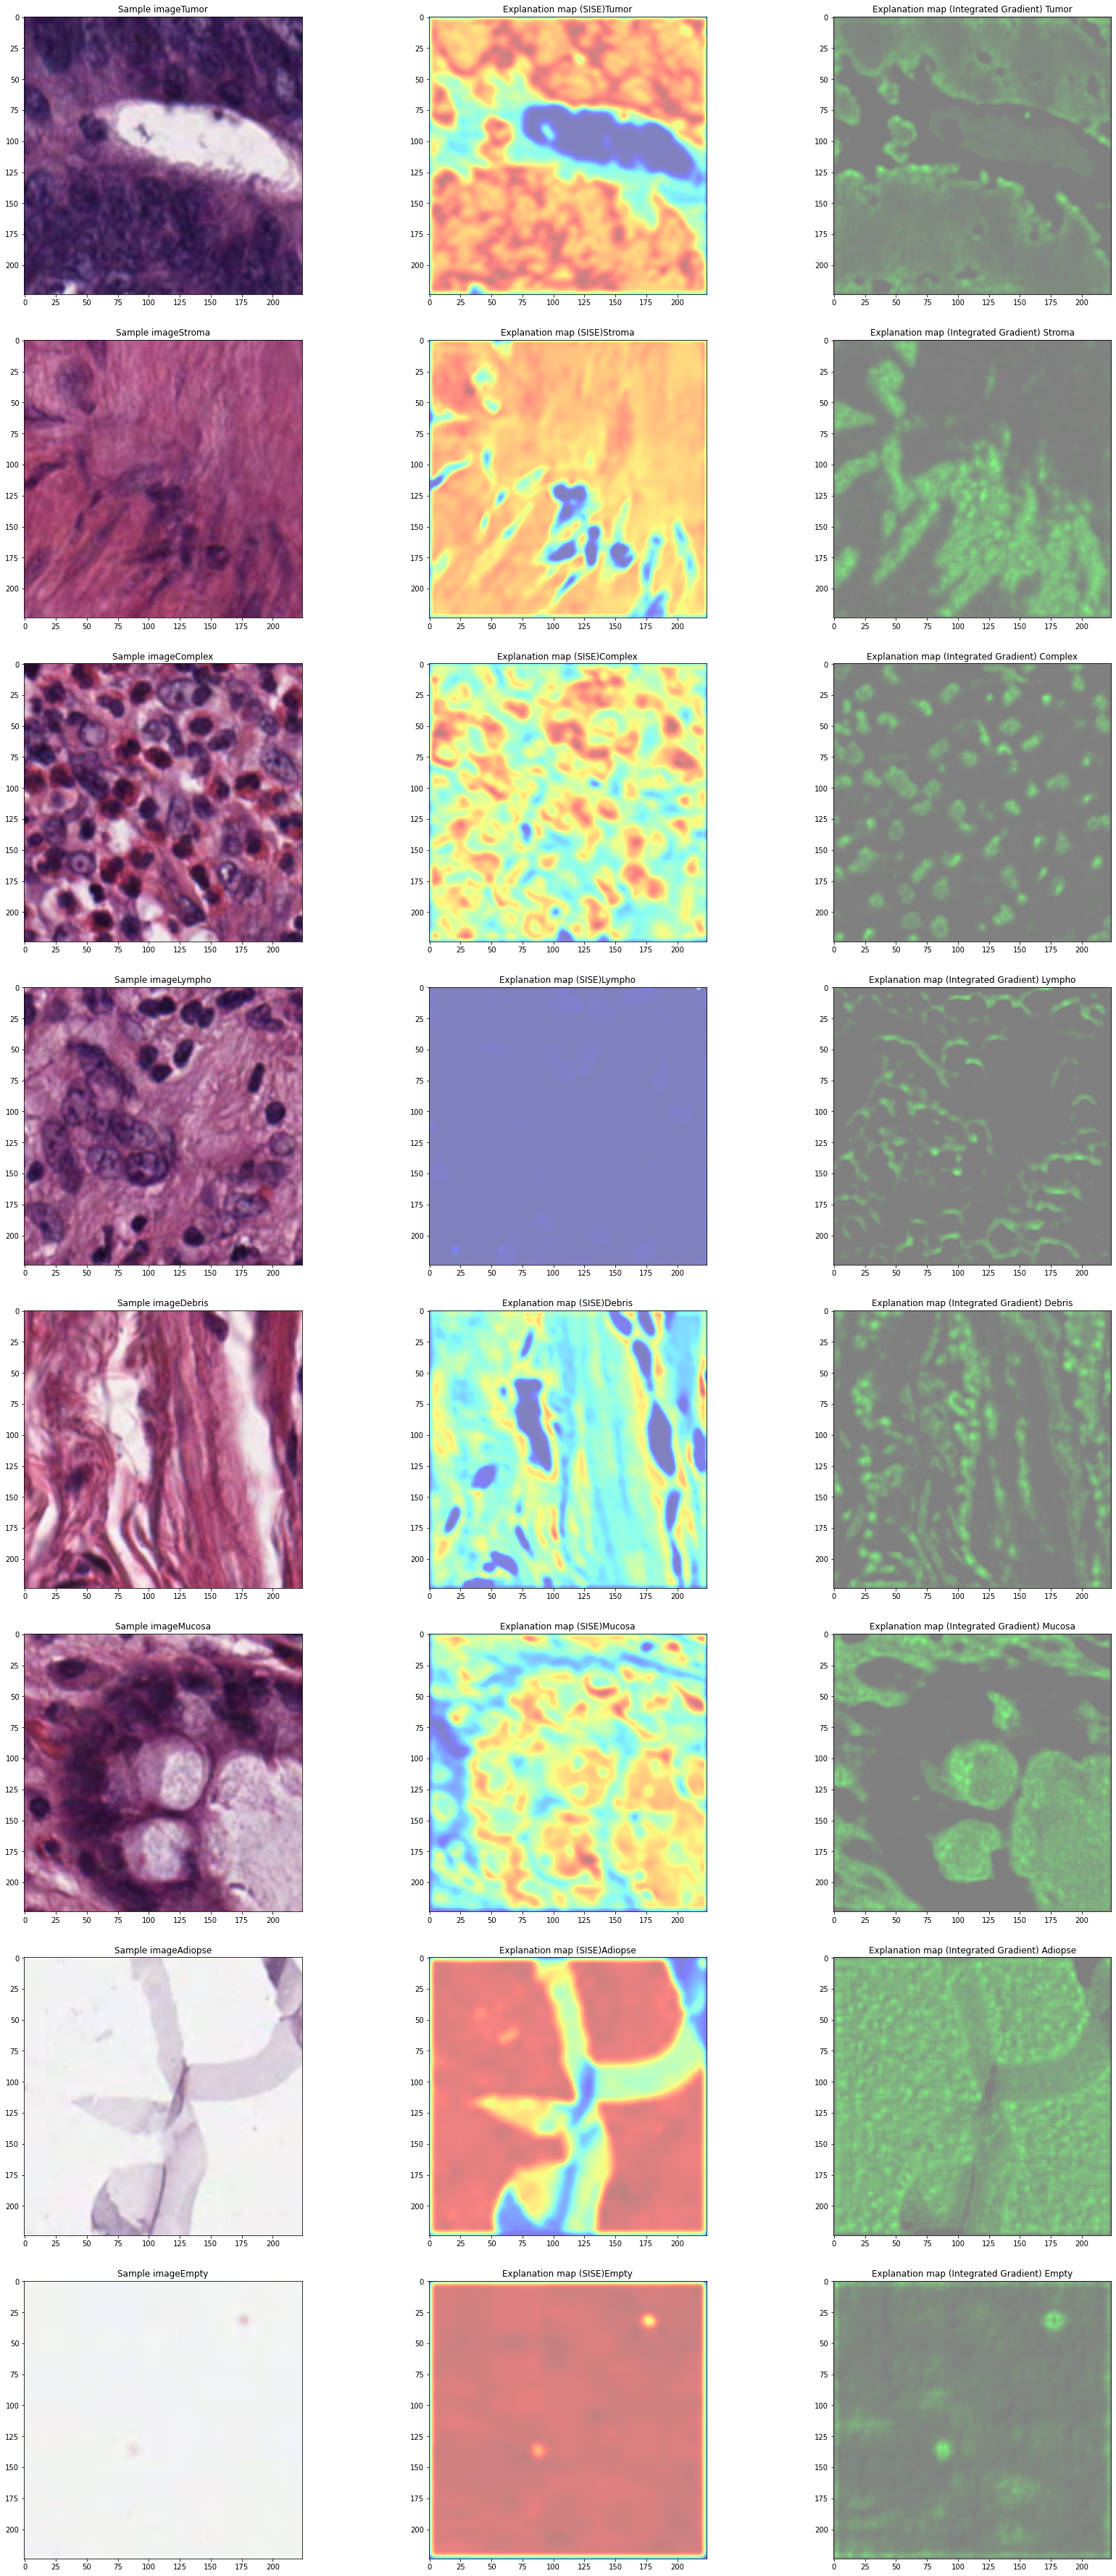

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs= plt.subplots(8,3,figsize=(25,50))
#fig,axs=plt.subplot(8,3,figsize=(25,25))
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty'] 
sample = []
f=-1
while len(sample) < 8:
  image_batch,label_batch=test_generator.next()
  for i,j in enumerate(label_batch.argmax(axis=1)):
    if j not in sample:
      sample.append(j)
      f +=1

      axs[f,0].imshow(image_batch[i])
      axs[f,0].set_title('Sample image'+ classes[j])

      explanation_map_SISE = SISE(np.expand_dims(image_batch[i], axis=0), model, layers=[['conv2d_3']], class_index=j, grad_thr=0.)
      explanation_map_SISE -= explanation_map_SISE.min()
      explanation_map_SISE /= explanation_map_SISE.max()+10e-30

      axs[f,1].imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
      #axs[f,1].axis('off')
      axs[f,1].set_title('Explanation map (SISE)' + classes[j])


      explanation_map_Intgrad=Integrated_gradient(image_batch[i], model, label=j)
      axs[f,2].imshow(explanation_map_Intgrad, cmap='jet', alpha=0.5)
      #axs[f,2].axis('off')
      axs[f,2].set_title('Explanation map (Integrated Gradient) '+ classes[j])  

plt.tight_layout(pad=3.0)
plt.show()
plt.savefig('/content/drive/My Drive/torchray_master/XAI_HMT.png')

## Quantitative evaluation of the explanation algorithm

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
val_generator.reset()
drop_rate = 0.
increase_rate=0.
for _ in range(5):
    image_batch,label_batch=val_generator.next()
    for index in range(32):
      #print(index) 
      prediction=model(image_batch)
      explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
      d,i,_,_= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)
      drop_rate +=d
      increase_rate +=i
drop_rate /= (5*32)
increase_rate /= (5*32)
print("For SISE, we have a drop rate of "+ str(drop_rate)+" and a increase rate of "+ str(increase_rate))

For SISE, we have a drop rate of 0.6808800088045825 and a increase rate of 0.025


In [ ]:
val_generator.reset()
drop_rate = 0.
increase_rate=0.
for _ in range(5):
    image_batch,label_batch=val_generator.next()
    for index in range(32):
      #print(index)
      prediction=model(image_batch)
      explanation_map = Integrated_gradient(image_batch[index], model, label=np.argmax(prediction[index]))
      d,i,_,_= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map[:,:,1], class_index=np.argmax(prediction[index]), frac=0.3)
      drop_rate +=d
      increase_rate +=i
drop_rate /= (5*32)
increase_rate /= (5*32)
print("For integrated gradient, we have a drop rate of "+ str(drop_rate)+" and a increase rate of "+ str(increase_rate))

For integrated gradient, we have a drop rate of 0.99375 and a increase rate of 0.00625
